<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Constants
Set these to make things run faster. In order to use the maximize these constants, just set them to `None`.

In [27]:
NUM_CASES    = 300  # Number of cases (spacys tokenization is quite slow)
TFIDF_LIMIT  = 5000 # Limit for tfidf task (cosine similarity has non-linear runtime)
KMEANS_LIMIT = 2000 # Limit for K-Means clustering (also non-linear runtime)

TEST_RATIO = .1 # Test ratio for Machine Learning tasks

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Exercise 1

Load all Cases into dictionaries:

In [9]:
import os
import numpy as np
from zipfile import ZipFile

cnt = 1
last_action = ""
def counter_message(max_cnt, action):
    """Displays Progress
    """
    global cnt, last_action
    
    #Reset Counter for every new action
    if last_action != action:
        cnt = 1
        last_action = action
    
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)
    cnt += 1

zfile = ZipFile("data/cases.zip")
caseids = []
raw_texts = {}
years = {}


# Randomly shuffle files and choose as many as we need
members = zfile.namelist()
if NUM_CASES is None:
    NUM_CASES = len(members)
    
processed_files = np.random.permutation(members)[:NUM_CASES]

for case in processed_files:
    year, caseid = case[:-4].split("_")
    with zfile.open(case) as f:
        raw_text = f.read().decode()
    raw_texts[caseid] = raw_text
    years[caseid] = int(year)
    caseids.append(caseid)
    counter_message(NUM_CASES, "opened")


300/300: opened.                                                                      

In [12]:
raw_text[:50]

' VAN VALKENBURGH , Circuit Judge.\nAppellant Sponen'

Convert to `spacy` documents:

In [15]:
import spacy
nlp = spacy.load('en') # requires:python -m spacy download en

spacy_documents = {}
for caseid in caseids:
    spacy_documents[caseid] = nlp(raw_texts[caseid])
    counter_message(NUM_CASES, "converted")
    

300/300: converted.          

Count sentences, words and letters and make histogram:

300/300: counted features.                                                                                                                       

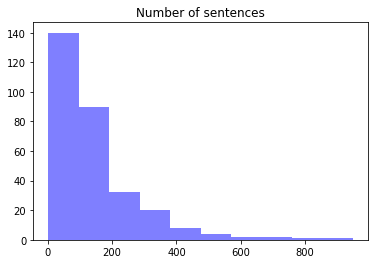

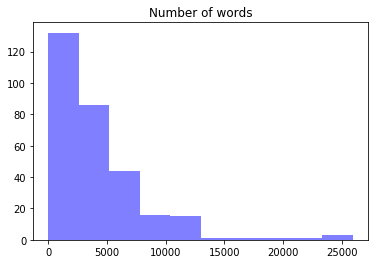

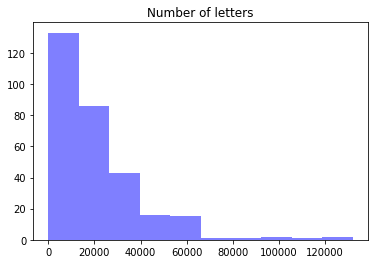

In [16]:
import matplotlib.pyplot as plt

# Display plots directly inline
%matplotlib inline 

def make_hist(data, title = "", num_bins = 10):
    """Make histogram for some data
    """
    plt.hist(data, num_bins, facecolor='blue', alpha=.5)
    plt.title(title)
    plt.show()

num_sents = []
num_words = []
num_letters = []

# Count Sentences, Words and Letters in all documents
for caseid in caseids:
    num_sents.append(len(list(spacy_documents[caseid].sents)))
    num_words.append(len(list(spacy_documents[caseid])))
    num_letters.append(len(raw_texts[caseid]))
    counter_message(NUM_CASES, "counted features")

# Draw Plots
make_hist(num_sents, "Number of sentences")
make_hist(num_words, "Number of words")
make_hist(num_letters, "Number of letters")

# Exercise 2

Plot verb/adjective/noun frequencies over the years

300/300: counted word types.                                                                                                                                                                                                                                     

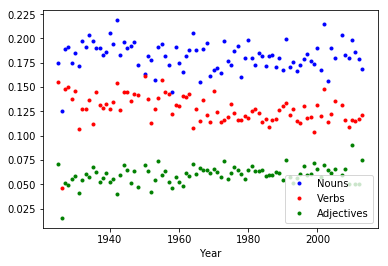

In [28]:
min_year = years[min(years, key=years.get)] # Get The first year
max_year = years[max(years, key=years.get)] # Get last year

# Create buckets for verbs, adjectives and nouns in order to count them for each year
year_range = np.arange(min_year, max_year+1)
verb_counts = np.zeros(len(year_range))
adj_counts = np.zeros(len(year_range))
noun_counts = np.zeros(len(year_range))

word_counts = np.zeros(len(year_range)) # to get frequencies from count

# Count verbs, adjectiv
for caseid in caseids:
    spacy_document = spacy_documents[caseid]
    num_verbs = 0
    num_adjs = 0
    num_nouns = 0
    for token in spacy_document:
        if token.pos_ == "VERB":
            num_verbs += 1
        elif token.pos_ == "ADJ":
            num_adjs += 1
        elif token.pos_ == "NOUN":
            num_nouns += 1
    
    index = years[caseid] - min_year 
    verb_counts[index] += num_verbs
    adj_counts[index] += num_adjs
    noun_counts[index] += num_nouns
    word_counts[index] += len(spacy_document)
    counter_message(NUM_CASES, "counted word types")

# Make frequencies from counts
# There are going to be some warnings caused by zero-division if there is no data for some years
verb_counts = np.divide(verb_counts, word_counts, dtype = np.float32)
adj_counts = np.divide(adj_counts, word_counts, dtype = np.float32)
noun_counts = np.divide(noun_counts, word_counts, dtype = np.float32)

fig, verb_ax = plt.subplots()

plt.plot(year_range, noun_counts, 'b.')
plt.plot(year_range, verb_counts, 'r.')
plt.plot(year_range, adj_counts, 'g.')

plt.xlabel('Year')
legend = plt.legend(["Nouns","Verbs","Adjectives"])



# Exercise 3

Lemmatize corpus. We get rid of all whitespace and punctuation in order to just extract the relevant information. We use `spacy` to lemmatize the text (just base form of all words) and then remove any punctuation.


In [18]:
from nltk import ngrams
import string

def normalize(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

noun_ngrams = {}
total_ngrams = []
word_counts= {}

# Lemmatize Cases
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:
        
        if not token.is_punct and not token.is_space: # Ignore spaces (newlines etc) and punctuation
            tokens.append(token)
            norm = normalize(token)
            
            if not norm in word_counts: # We've seen the word for the first time
                word_counts[norm] = 1
            else:                       # We already know this word
                word_counts[norm] += 1

    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[2].pos_ == "NOUN": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
            total_ngrams.append(curr_ngram) # Stores 3-grams for all cases
    
    noun_ngrams[caseid] = noun_ngram
    counter_message(NUM_CASES, "lemmatized")


300/300: lemmatized.                                                                                                             

In [20]:
noun_ngram[:20]

[('sponenbarger', 'own', 'forty'),
 ('own', 'forty', 'acre'),
 ('acre', 'of', 'land'),
 ('PRON', 'file', 'action'),
 ('4120', 'for', 'compensation'),
 ('the', 'allege', 'taking'),
 ('PRON', 'say', 'property'),
 ('PRON', 'fair', 'market'),
 ('fair', 'market', 'value'),
 ('as', 'a', 'result'),
 ('of', 'the', 'establishment'),
 ('include', 'the', 'land'),
 ('land', 'in', 'question'),
 ('question', 'under', 'authority'),
 ('1928', '33', 'usca'),
 ('usca', '702a', 'et'),
 ('702a', 'et', 'seq'),
 ('the', 'destructive', 'flood'),
 ('congress', 'into', 'recognition'),
 ('of', 'the', 'fact')]

# Exercise 4

Exercise 4 is combined with the start of Exercise First save all the outcomes into a dictionary and then create two numpy arrays X holding the features and y holding the outcome. At the end standardize X in order to have variance = 1 for every entry.

In [24]:
import pandas as pd
from collections import Counter

# Load outcomes into dictionary
outcomes = {}
case_reversed = pd.read_csv("data/case_reversed.csv").values
for caseid, outcome in case_reversed:
    outcomes[caseid] = outcome

X = []
y = []

# Get most common n_grams
most_common = Counter(total_ngrams).most_common()

for caseid in caseids:
    current_ngram = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i in range(len(most_common)):
        ngram = most_common[i][0]
        if ngram in current_ngram: #Only add most common 3-gram frequencies
            features[i] = current_ngram[ngram]
    X.append(features)
    y.append(outcomes[caseid])
    counter_message(NUM_CASES, "created ML features")

# convert to numpy array
X = np.array(X)

#standardize; maintain sparsity by not taking out the mean
X = X / np.std(X, axis=0)
y = np.array(y)


300/300: created ML features.                                                                                                                      

# Exercise 5 

Load outcome and link features with outcome

In [29]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

#Shuffle Dataset
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]

#Split into test & train dataset

test_amount = int(X.shape[0]*TEST_RATIO)

test_X = X[:test_amount]
test_y = y[:test_amount]
train_X = X[test_amount:]
train_y = y[test_amount:]

# Fit Logistic Regression Model with standard parameters
clf = LogisticRegression().fit(train_X, train_y)

# Make prediction
y_pred = clf.predict(test_X)

# Determine accuracy
accuracy = accuracy_score(y_pred, test_y)
f1 = f1_score(y_pred, test_y)

print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))


accuracy: 0.6333
f1 score: 0.7755


# Exercise 6

Using Grid search to find optimal parameters

In [30]:
from sklearn.model_selection import GridSearchCV

# Apply Grid Search
parameters = {'penalty':('l1', 'l2'), 'C':[.1, 10]}
lreg = LogisticRegression()
clf = GridSearchCV(lreg, parameters, cv=5)
clf.fit(train_X,train_y)

# Make Predictions
y_pred = clf.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(y_pred, test_y)
f1 = f1_score(y_pred, test_y)

params = clf.get_params()
C_opt = params['estimator__C']
penalty_opt = params['estimator__penalty']

print("Optimal C:       {}".format(C_opt))
print("Optimal Penalty: {}".format(penalty_opt))
print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))


Optimal C:       1.0
Optimal Penalty: l2
accuracy: 0.6000
f1 score: 0.7500


# Exercise 7

Get sentiments of sentences and put data into a `pandas` dataframe

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentences = []
sid = SentimentIntensityAnalyzer()

for caseid in caseids:
    # Go through every sentence of every case
    for sentence in spacy_documents[caseid].sents:
        text = sentence.text.replace("\n","")      
        polarity_scores = sid.polarity_scores(sentence.string) #Get sentiment
        positive = polarity_scores['pos']
        neutral  = polarity_scores['neu']
        negative = polarity_scores['neg']

        analyzed_sentence = [text, positive, neutral, negative]
        
        if analyzed_sentence not in sentences: # Make sure not to add any duplicates
            sentences.append(analyzed_sentence)
            
    counter_message(NUM_CASES, "Sentiment analysis")

# Make pandas dataframe
sentences_df = pd.DataFrame(sentences, columns=["Sentence","Positive","Neutral","Negative"])

300/300: Sentiment analysis.                                                 

Top 10 positive sentences

In [12]:
sentences_df.sort_values("Positive", ascending=False).head(10)

Sentence  Positive  Neutral  Negative
4796                        143     1.000    0.000       0.0
27262                    Super.     1.000    0.000       0.0
10518                     143 .     1.000    0.000       0.0
33626  Justice O'Connor agreed.     0.846    0.154       0.0
38296               BL 234889 ]     0.801    0.199       0.0
27813   The Interest of Justice     0.762    0.238       0.0
5768            Public Interest     0.750    0.250       0.0
30481           United States."     0.737    0.263       0.0
15348              United Auto.     0.737    0.263       0.0
31413            C. Opportunity     0.737    0.263       0.0

Top 10 negative sentences 

In [13]:
sentences_df.sort_values("Negative", ascending=False).head(10)

Sentence  Positive  Neutral  Negative
25944                             Ill.       0.0    0.000     1.000
8142                               No.       0.0    0.000     1.000
25013                               No       0.0    0.000     1.000
39880                            No. 2       0.0    0.000     1.000
11776  Indefinite Punitive Isolation .       0.0    0.143     0.857
3249                        185, 187 ,       0.0    0.196     0.804
35507               , 182 U.S.App.D.C.       0.0    0.204     0.796
22344                       182, 183 ,       0.0    0.204     0.796
24380                  OVERALL FAILURE       0.0    0.233     0.767
33426             No. 187, 86th Cong.,       0.0    0.241     0.759

# Exercise 8

Compute tf-idf frequencies

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()

if TFIDF_LIMIT is None:
    TFIDF_LIMIT = len(sentences_df["Sentence"])

X = vectorizer.fit_transform(sentences_df["Sentence"][:TFIDF_LIMIT])
cos_sim = cosine_similarity(X) #not feasible for too many sentences

# Go through everything and get most and least similar.
most_similar = [0,(0,0)]
least_similar = [1,(0,0)]
for x in range(TFIDF_LIMIT):
    for y in range(x+1,TFIDF_LIMIT):
        similarity = cos_sim[x][y]
        if similarity > most_similar[0]:
            most_similar = [similarity,(x,y)]
        elif similarity < least_similar[0]:
            least_similar = [similarity,(x,y)]    

Most similar sentences:



In [16]:
sim = most_similar[0]
sent1 = sentences_df["Sentence"][most_similar[1][0]]
sent2 = sentences_df["Sentence"][most_similar[1][1]]
print('Similarity: {:.4f}\n"{}"\n"{}"'.format(sim, sent1, sent2))

Similarity: 1.0000
"See id ."
"See id."


Least similar sentences

In [17]:
sim = least_similar[0]
sent1 = sentences_df["Sentence"][least_similar[1][0]]
sent2 = sentences_df["Sentence"][least_similar[1][1]]
print('Similarity:{:.4f}\n"{}"\n"{}"'.format(sim, sent1, sent2))

Similarity:0.0000
" CALLAHAN, Circuit Judge: OPINION SUMMARY [fn"
"*]"


# Exercise 9

K-Means (again, limiting number of sentences)

In [20]:
from sklearn.cluster import KMeans

if KMEANS_LIMIT is None:
    KMEANS_LIMIT = X.shape[0]

# Perform KMeans clustering
kmeans = KMeans(n_clusters=20).fit(X[:KMEANS_LIMIT])

# Create an array holding indices for every cluster
examples = []
for i in range(20):
    examples.append([])
    
for i in range(len(kmeans.labels_)):
    label = kmeans.labels_[i]
    examples[label].append(i)

# print examples
n_examples = 5
for cluster in range(20):
    print("Cluster {}:".format(cluster))
    for i in range(min(n_examples, len(examples[cluster]))):
        example = examples[cluster][i]
        print(i,":",sentences_df["Sentence"][example])
    print()

Cluster 0:
0 :  CALLAHAN, Circuit Judge: OPINION SUMMARY [fn
1 : *]
2 : We have previously indicated that tacking only applies in "exceptionally narrow" circumstances, Brookfield Communications, Inc. v. West Coast Entertainment Corp. , 174 F.3d 1036 , 1047 (9th Cir.
3 : 1999), and is properly resolved "as a matter of law if reasonable minds cannot differ and the evidence permits only one conclusion," One Industries, LLC v. Jim O'Neal Distribution, Inc. , 578 F.3d 1154 , 1160
4 : I

Cluster 1:
0 : The deal, however, was never completed.
1 : They do not, however, support HFI's position in this case as strongly as it might appear at first glance.
2 : [fn9] That the evidence could be construed to support HFI's position, however, is not enough for it to prevail.
3 : It is well-settled, however, that registration is not necessarily dispositive of ownership.
4 : We do not agree.

Cluster 2:
0 : Section
1 : "Section 205(a) of the Social Security Act as amended, Section 405(a),
2 : regs/documen